In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

In [2]:
def load_data(filepath):
    """
    Load the dataset from the specified file path.
    
    Parameters:
    filepath (str): The path to the dataset file.
    
    Returns:
    pd.DataFrame: The loaded dataset.
    """
    return pd.read_csv(filepath)

In [3]:
# Load the dataset
filepath = '/kaggle/input/crop-production-india/crop_production.csv'
df = load_data(filepath)

In [4]:
def initial_inspection(df):
    """
    Perform initial inspection of the dataset.
    
    Parameters:
    df (pd.DataFrame): The dataset to inspect.
    
    Returns:
    None
    """
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nChecking for null values:")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "No null values found.")

    print("\nChecking for duplicate rows:")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}" if duplicates > 0 else "No duplicate rows found.")
    
    for col in df.select_dtypes(include=['object']).columns:
        unique_values = df[col].unique()
        num_unique_values = len(unique_values)
        print(f"\nColumn '{col}' has {num_unique_values} unique values.")
        if num_unique_values > 10:
            print(f"First 10 unique values: {unique_values[:10]} ...")
        else:
            print(unique_values)
    
    print("\nNumber of districts per state:")
    state_district_counts = df.groupby('State_Name')['District_Name'].nunique()
    print(state_district_counts)

In [5]:
# Perform EDA
initial_inspection(df)

First 5 rows of the dataset:
                    State_Name District_Name  Crop_Year       Season  \
0  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    

                  Crop    Area  Production  
0             Arecanut  1254.0      2000.0  
1  Other Kharif pulses     2.0         1.0  
2                 Rice   102.0       321.0  
3               Banana   176.0       641.0  
4            Cashewnut   720.0       165.0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   Dis

# Information obtained from intial inspection
**columns: State_Name, District_Name, Crop_Year, Season, Crop, Area, Production.**

**246,091 entries and 7 columns.**

**There are no duplicates, But Production column has 3,730 missing values.**

**Data is collected from 1997 to 2015**


In [6]:
def clean_data(df):
    """
    Clean the dataset by handling missing values, removing duplicates, and ensuring appropriate data types.
    
    Parameters:
    df (pd.DataFrame): The dataset to clean.
    
    Returns:
    pd.DataFrame: The cleaned dataset.
    """
    # Handle missing values using KNN imputation for 'Production' column
    imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors as needed
    df['Production'] = imputer.fit_transform(df[['Production']])  
    
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    
    return df

In [7]:
df = clean_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null  int64  
 3   Season         246091 non-null  object 
 4   Crop           246091 non-null  object 
 5   Area           246091 non-null  float64
 6   Production     246091 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.1+ MB


**All of the missing values have been filled with KNN**

In [8]:
def explore_data(df):
    """
    Explore the dataset by calculating summary statistics and plotting distributions.
    
    Parameters:
    df (pd.DataFrame): The dataset to explore.
    
    Returns:
    None
    """


    # Plot production vs year
    plt.figure(figsize=(10, 6))
    production_per_year = df.groupby('Crop_Year')['Production'].sum()
    sns.lineplot(x=production_per_year.index, y=production_per_year.values)
    plt.title('Total Production vs Year')
    plt.xlabel('Year')
    plt.ylabel('Total Production')
    plt.show()

    # State vs production per year plot
    plt.figure(figsize=(20, 10))
    state_year_production = df.groupby(['State_Name', 'Crop_Year'])['Production'].sum().unstack()
    sns.heatmap(state_year_production, cmap='YlGnBu', cbar_kws={'label': 'Total Production'})
    plt.title('State vs Production per Year')
    plt.xlabel('Year')
    plt.ylabel('State')
    plt.show()

    # Highest production crop in each state
    highest_production_crop = df.groupby(['State_Name', 'Crop'])['Production'].sum().reset_index()
    idx = highest_production_crop.groupby('State_Name')['Production'].idxmax()
    highest_production_crop = highest_production_crop.loc[idx].set_index('State_Name')
    
    print("\nHighest production crop in each state:")
    for state, row in highest_production_crop.iterrows():
        print(f"{state}: {row['Crop']} with production {row['Production']}")

    # Each state total area vs production per state
    plt.figure(figsize=(20, 10))
    state_area_production = df.groupby('State_Name')[['Area', 'Production']].sum().reset_index()
    sns.scatterplot(data=state_area_production, x='Area', y='Production', hue='State_Name', sizes=(20, 200))
    plt.title('Total Area vs Production per State')
    plt.xlabel('Total Area')
    plt.ylabel('Total Production')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # State with highest production per year
    plt.figure(figsize=(20, 10))
    state_highest_production_year = df.groupby(['Crop_Year', 'State_Name'])['Production'].sum().reset_index()
    idx = state_highest_production_year.groupby('Crop_Year')['Production'].idxmax()
    state_highest_production_year = state_highest_production_year.loc[idx]
    sns.barplot(x='Crop_Year', y='Production', hue='State_Name', data=state_highest_production_year)
    plt.title('State with Highest Production per Year')
    plt.xlabel('Year')
    plt.ylabel('Total Production')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # List of districts with highest productions per state
    highest_production_district = df.groupby(['State_Name', 'District_Name'])['Production'].sum().reset_index()
    idx = highest_production_district.groupby('State_Name')['Production'].idxmax()
    highest_production_district = highest_production_district.loc[idx].set_index('State_Name')
    
    print("\nDistricts with highest productions per state:")
    for state, row in highest_production_district.iterrows():
        print(f"{state}: {row['District_Name']} with production {row['Production']}")

    # Which season has highest crops per year
    plt.figure(figsize=(20, 10))
    season_year_crop = df.groupby(['Crop_Year', 'Season'])['Production'].sum().reset_index()
    sns.barplot(x='Crop_Year', y='Production', hue='Season', data=season_year_crop)
    plt.title('Season with Highest Crops per Year')
    plt.xlabel('Year')
    plt.ylabel('Total Production')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


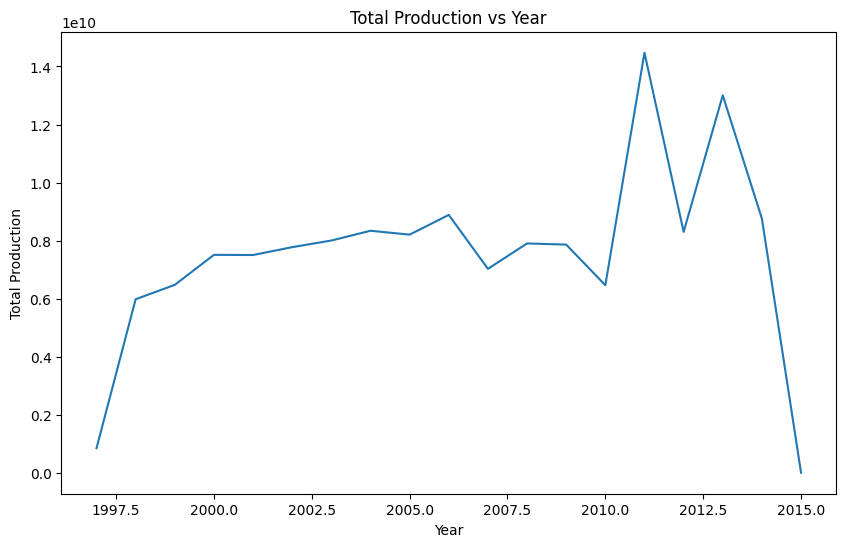

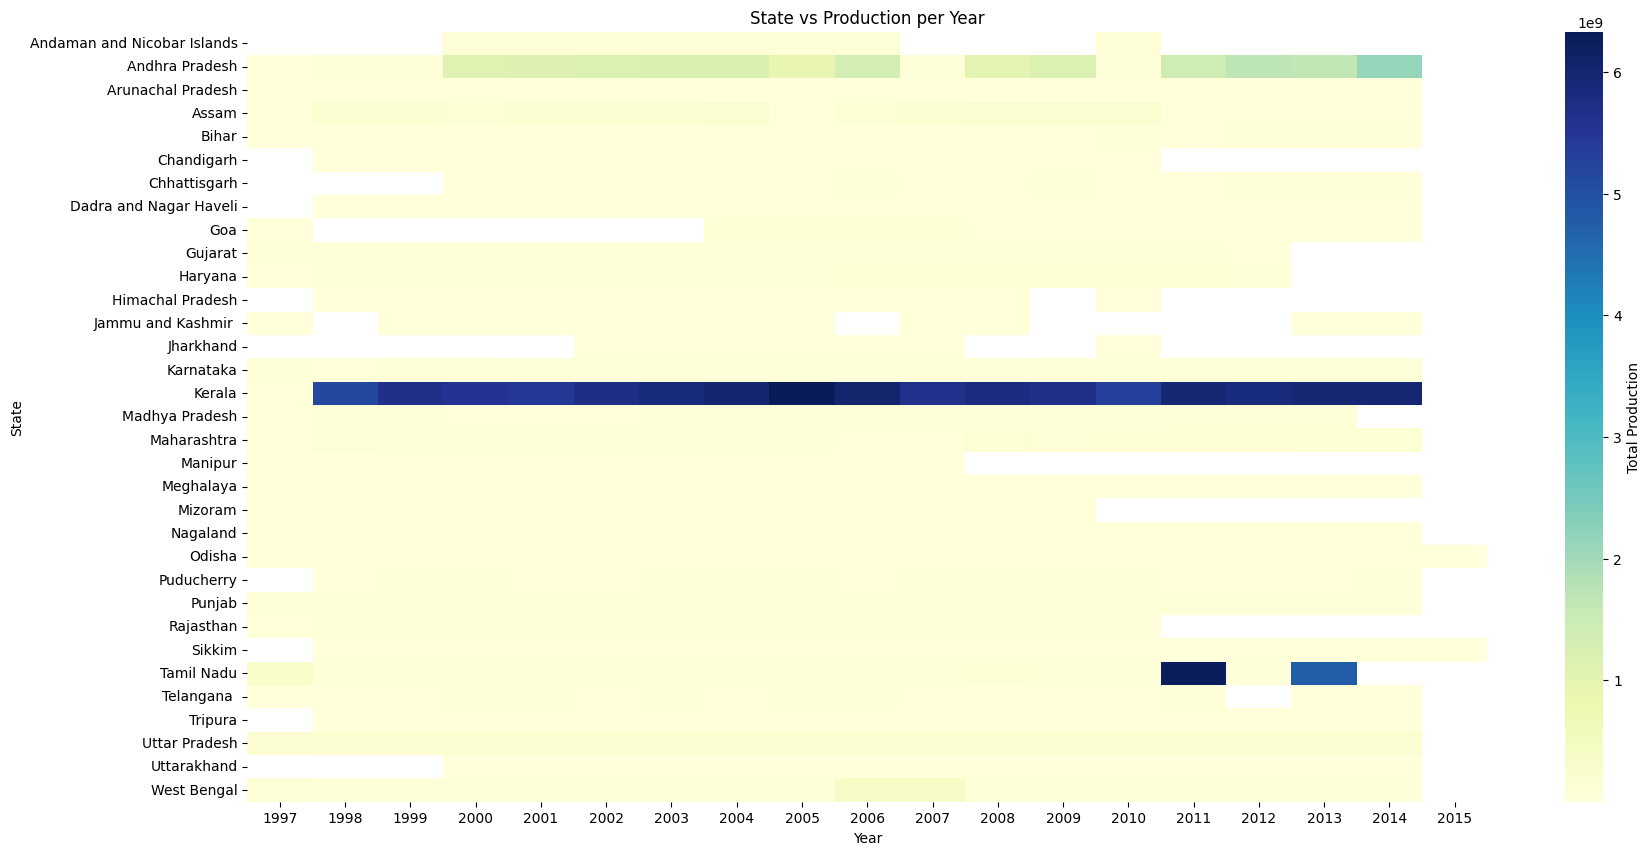


Highest production crop in each state:
Andaman and Nicobar Islands: Coconut  with production 717790000.0
Andhra Pradesh: Coconut  with production 16806002260.0
Arunachal Pradesh: Rice with production 2709476.6
Assam: Coconut  with production 1954408105.0
Bihar: Sugarcane with production 106227183.0
Chandigarh: Arhar/Tur with production 582591.4422509808
Chhattisgarh: Rice with production 82663624.88450196
Dadra and Nagar Haveli: Sugarcane with production 1115995.0
Goa: Coconut  with production 503112559.0
Gujarat: Sugarcane with production 212022800.0
Haryana: Wheat with production 158647000.0
Himachal Pradesh: Maize with production 7813360.0
Jammu and Kashmir : Maize with production 4753864.0
Jharkhand: Rice with production 7527411.94
Karnataka: Sugarcane with production 515845482.0
Kerala: Coconut  with production 97803036000.0
Madhya Pradesh: Wheat with production 147153856.0
Maharashtra: Sugarcane with production 938485965.0
Manipur: Rice with production 3850798.0
Meghalaya: Rice 

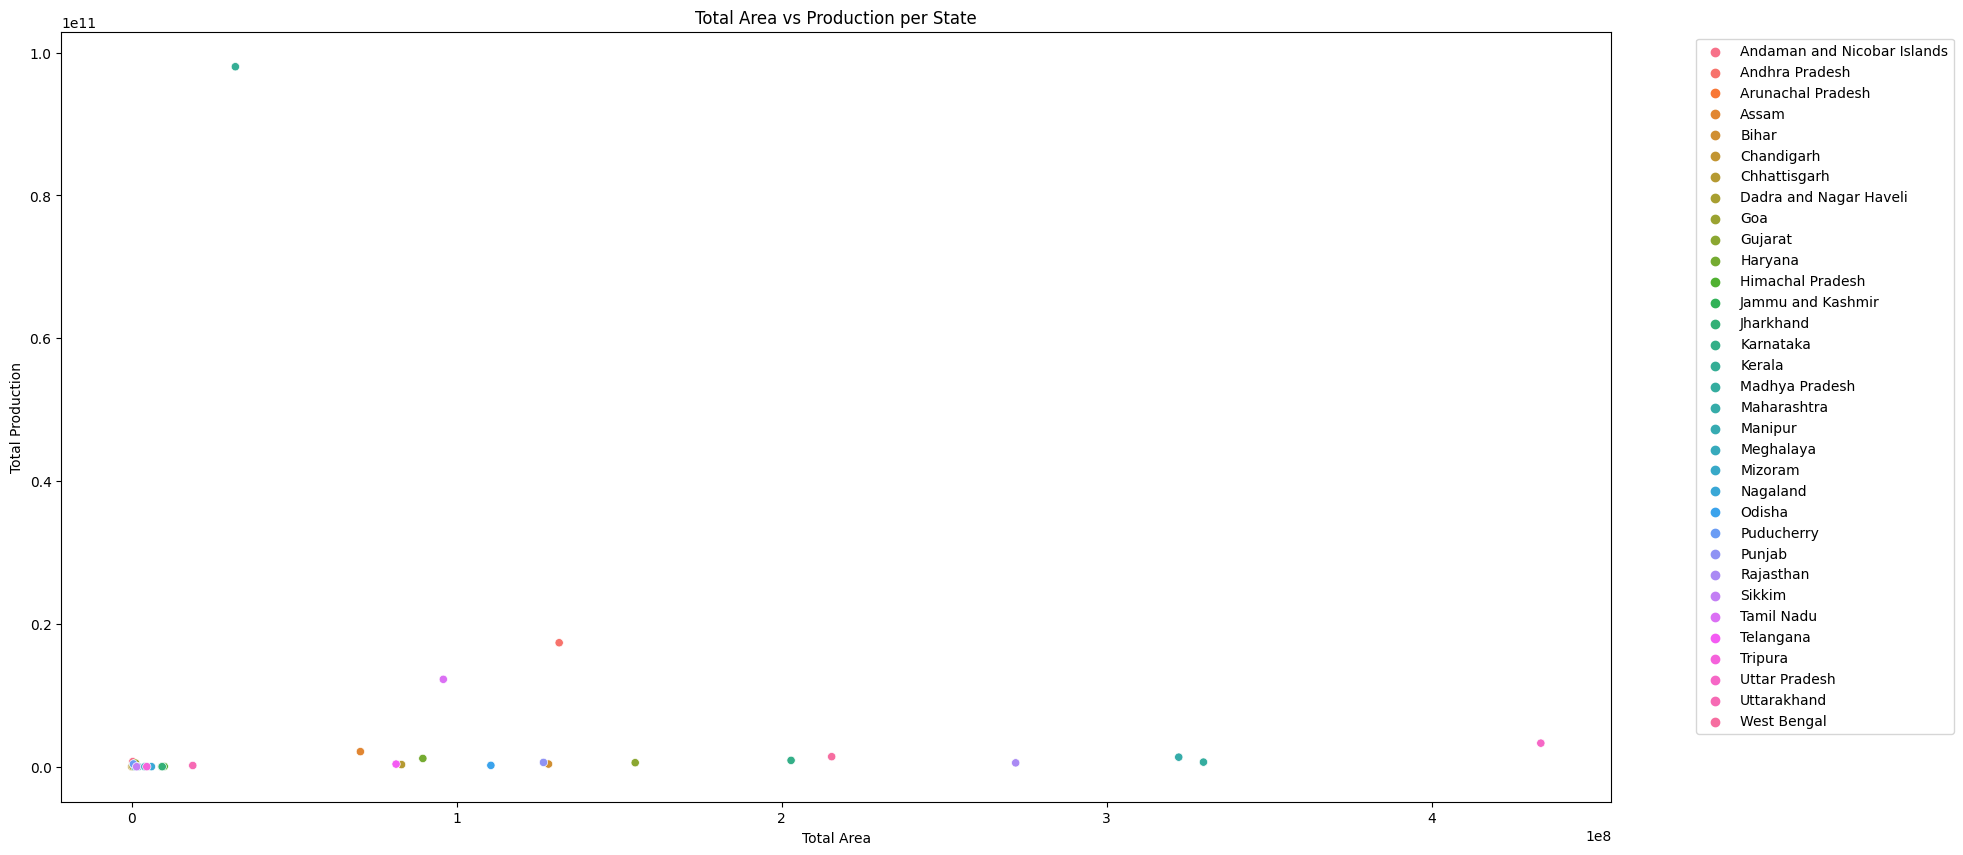

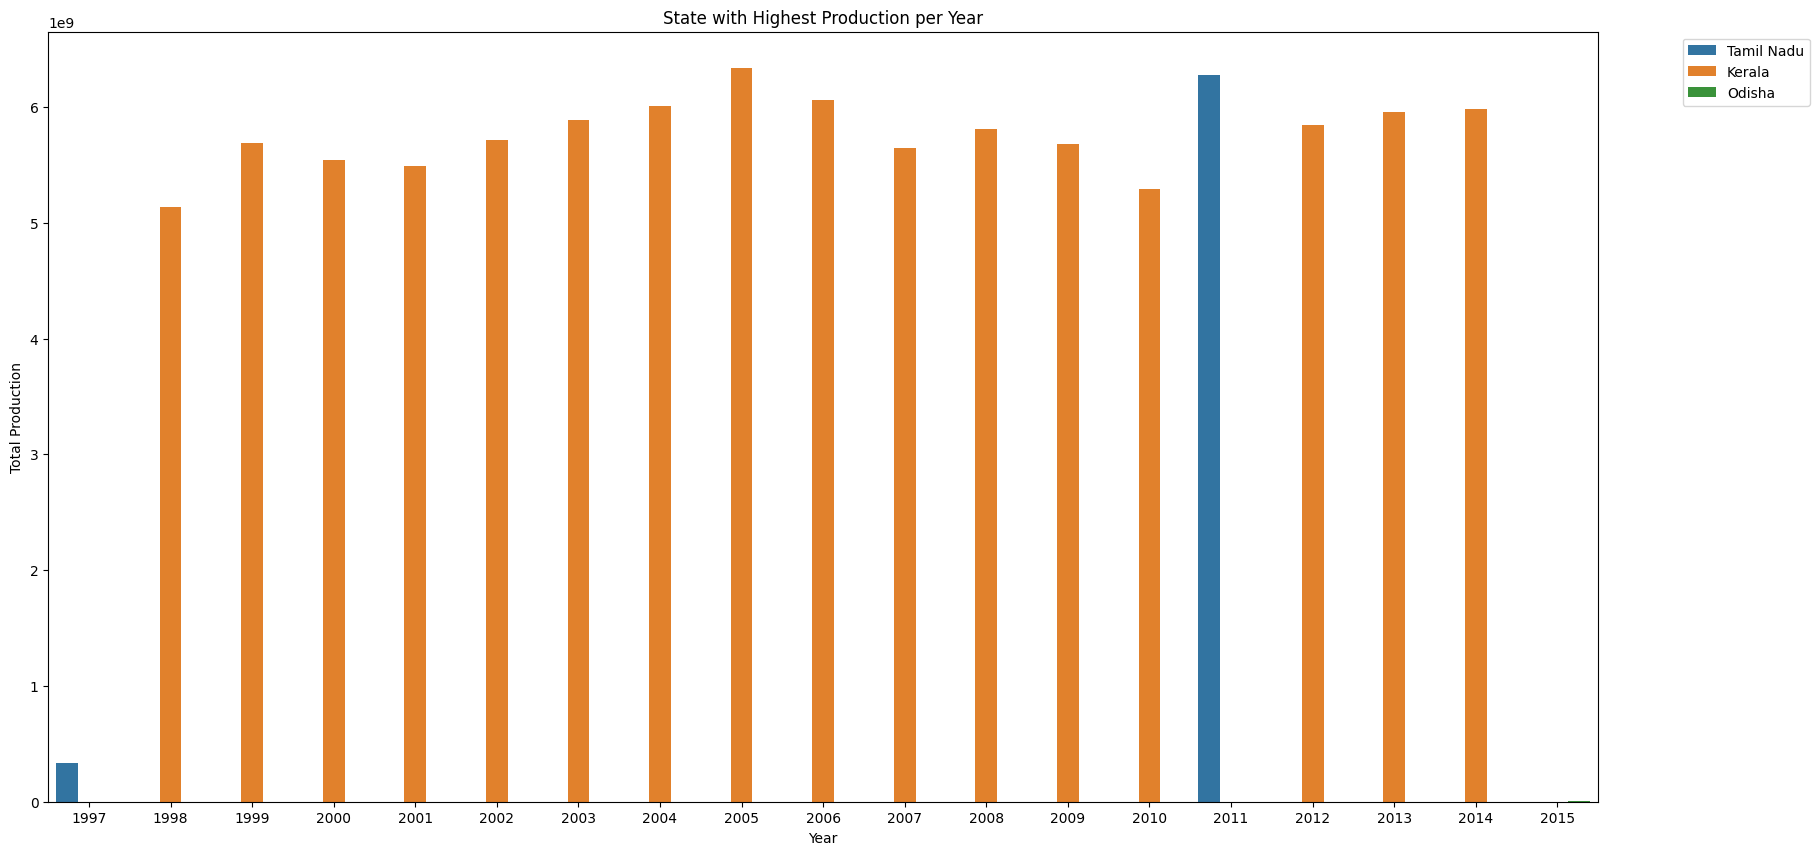


Districts with highest productions per state:
Andaman and Nicobar Islands: NICOBARS with production 501870464.13450193
Andhra Pradesh: EAST GODAVARI with production 8276299730.980259
Arunachal Pradesh: PAPUM PARE with production 1050781.1022509807
Assam: NAGAON with production 519185225.0
Bihar: PASHCHIM CHAMPARAN with production 66106851.0
Chandigarh: CHANDIGARH with production 646459.9422509808
Chhattisgarh: DANTEWADA with production 24532175.363286287
Dadra and Nagar Haveli: DADRA AND NAGAR HAVELI with production 1847871.0
Goa: SOUTH GOA with production 283378566.25225097
Gujarat: SURAT with production 138149015.53800786
Haryana: YAMUNANAGAR with production 87321397.82232945
Himachal Pradesh: HAMIRPUR with production 7084282.422509808
Jammu and Kashmir : JAMMU with production 2699229.8
Jharkhand: RANCHI with production 1420154.27
Karnataka: BELGAUM with production 218379743.16225097
Kerala: KOZHIKODE with production 15294719945.564024
Madhya Pradesh: CHHINDWARA with production 2536

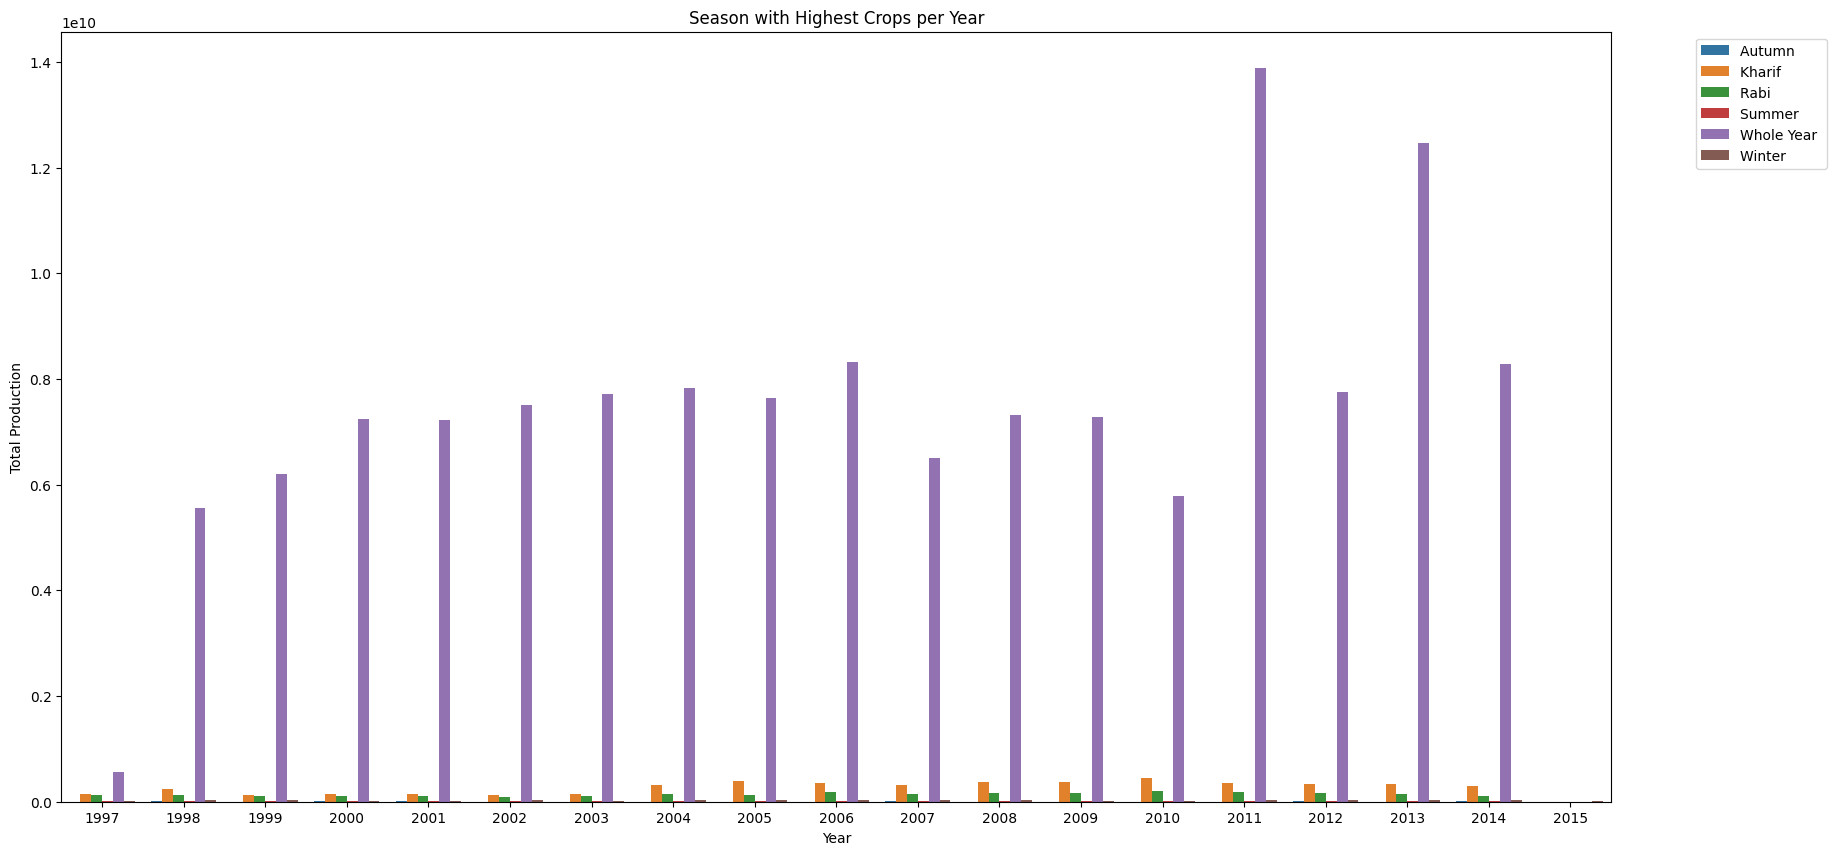

In [9]:
explore_data(df)

**The highest production occurred in 2011, and the lowest was in 2015.**

**Kerala produces lot more crops comparing to other states each year.**

**there is a small increase in production as area increased, then it didn't.**

**crop which grows whole year are produced in large amount comapred to others.**

**states which produce cocunut have very high production value compared to other states.**

**State with highest production per area ratio is kerala.**

In [10]:
def analyze_relationships(df):
    """
    Analyze relationships in the dataset using correlation matrix.
    
    Parameters:
    df (pd.DataFrame): The dataset to analyze.
    
    Returns:
    None
    """
    # Exclude non-numeric columns for correlation matrix
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    
    # Correlation matrix
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

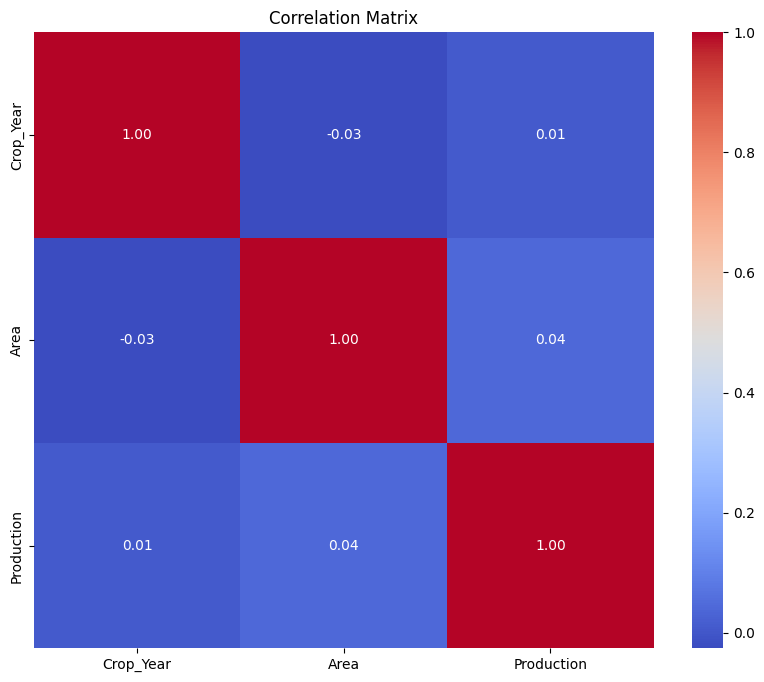

In [11]:
analyze_relationships(df)

**Correlation between them is very weak**